In [1]:
HTML_MODE = False
if not HTML_MODE:
    %matplotlib widget
else:
    %matplotlib inline

### 週販レポート2025年版
# 標準ライブラリ
import os
from datetime import datetime, timedelta

# サードパーティライブラリ
import pandas as pd
from pandas import Timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import Markdown, display

# プロジェクト内モジュール
from gamedata import hard_sales as hs
from gamedata import plot_hard as ph
from gamedata import hard_info as hi
from gamedata import hard_event as he

# レポート日付
from report_config import get_config

config = get_config()
report_date = config["date"]
hard_sales_df = hs.load_hard_sales()
# hard_sales_dfをフィルタリング、report_date以前のデータに
hard_sales_df = hard_sales_df.loc[hard_sales_df["report_date"] <= report_date]
hard_event_df = he.load_hard_event()


def show_title(d:datetime) -> None:
    last_updated_str = d.strftime("%Y-%m-%d")
    mode = "[[LAB MODE]]" if not HTML_MODE else ""
    display(Markdown(f"# 国内ゲームハード週販レポート ({last_updated_str}) {mode}"))

show_title(report_date)

if not HTML_MODE:
    plt.show()


# 国内ゲームハード週販レポート (2025-09-07) [[LAB MODE]]

* ハードウェアの販売データはファミ通の調査結果を元にしています。
* 一部のデータについては処理の都合上、1週間毎の値にアレンジしています。

## 直近4週間のハード売り上げ／累計推移


Switch2の供給がタイトです。一時的落ち込みではなくZA同梱版の大量出荷に備えて出荷を絞っている
状況と思われます。Switch2 200万台到達は9月18日の発表になりそうです。(9月14日にファミ通が速報を出す可能性はあります)

PS5の累計700万台は今のペースだと一週遅れて9月25日になりますが、9月4日から始まったオータムセールで
売り上げが加速すればSwitch2 200万と同時達成の可能性もあります。

In [2]:
def last4weeks_report(df: pd.DataFrame) -> pd.DataFrame:
    last4weeks_df = hs.extract_latest(df, weeks=4)[['report_date', 'full_name', 'units', 'sum_units']]
    
    last4weeks_df.set_index(['report_date', 'full_name'], inplace=True)
    last4weeks_df.sort_values(by=['report_date', 'units', 'full_name'], ascending=[True, False, True], inplace=True)

    # カラム名を日本語にする
    last4weeks_df.columns = ['販売数', '累計']
    # indexを日本語にする
    last4weeks_df.index.names = ['報告日', 'ハード']
    last4weeks_df.index = last4weeks_df.index.set_levels(
        last4weeks_df.index.levels[0].strftime('%Y-%m-%d'), level=0
    )
    # スタイルを適用して表示
    styled = last4weeks_df.style.format({'販売数': '{:,}', '累計': '{:,}'})
    return styled

display(last4weeks_report(hard_sales_df))

## 2025年の週販推移

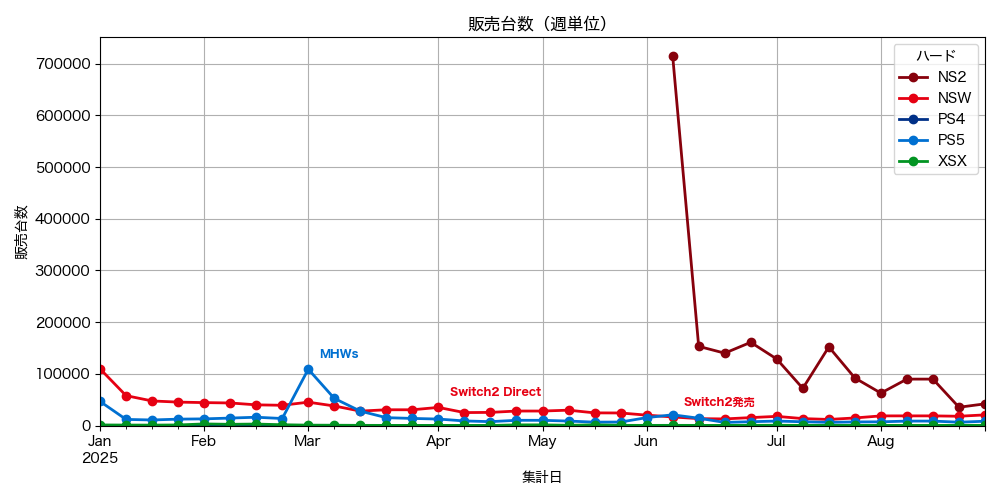

In [4]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), event_flag=True, event_priority=1)

### 2025年の週販推移(Switch2以外を拡大）

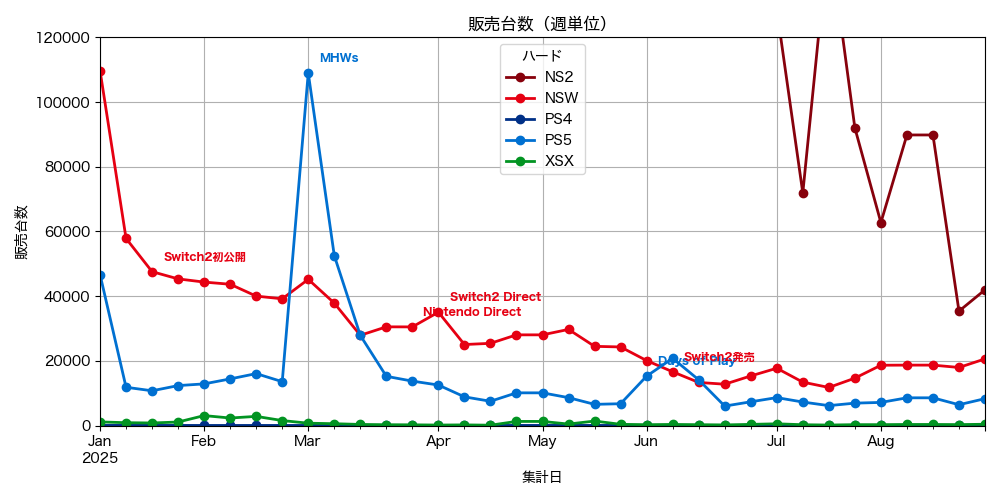

In [5]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), ymax=120000, event_flag=True, event_priority=3)

## 累計状況

#### 発売日からの累計販売状況

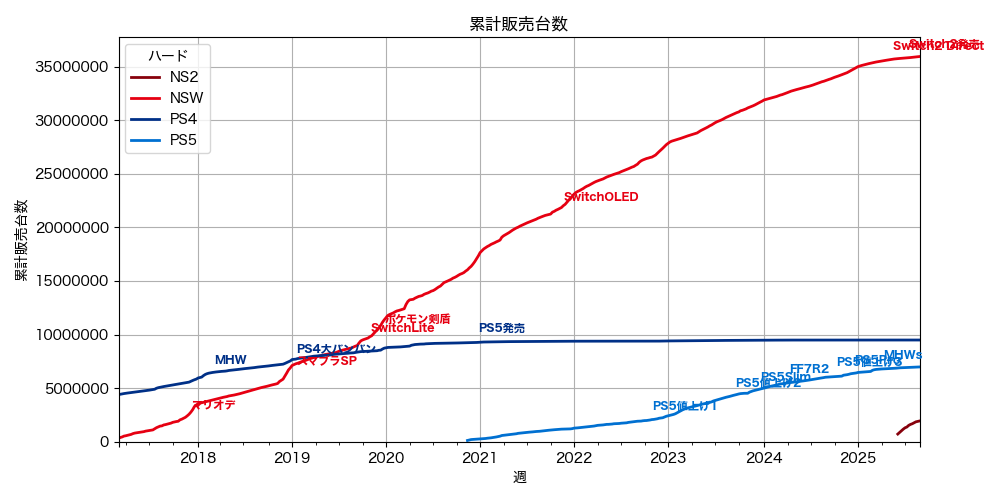

In [9]:
(fig, df) = ph.plot_cumulative_sales(hw=['PS4', 'NS2', 'PS5', 'NSW'], begin=datetime(2017,3,1), event_flag=True, event_priority=1.0)

## PS5の障壁？

巷で話題の「PS5の障壁」がハード売り上げデータ的に、どの程度のものか確認してみましょう。

### PS4/PS5累計比較

これはPS4、PS5それぞれの発売日起点の累計グラフです。実はPS4とPS5は殆ど差がありません。
結果的に差がないと言うより、常に、ほぼ同じ傾向であり続けています。不思議なことです。

細かく見ると、100週目あたりまでは、供給不足と言われながらもPS5はPS4とほぼ同数を売り上げ、
CFI1200にモデルチェンジし供給が改善されるとPS4を上回るペースで売り上げが上昇。
FF15, PS5Slimを迎えます。しかし値上げで伸びは鈍化し200週を過ぎてPS4を下回ります。


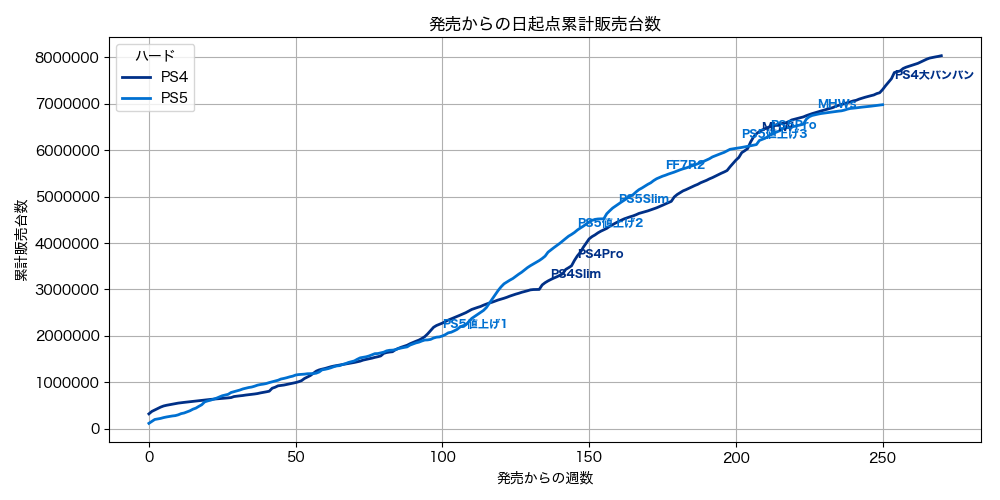

In [12]:
(fig, df) = ph.plot_cumulative_sales_by_delta(hw=['PS4', 'PS5'], end=270, event_priority=1, event_flag=True)

200週目あたりを詳しく見ます。モンスターハンターワールド、モンスターハンダーワイルズは、
このタイミングで発売日を迎えています。
PS4がMHW発売で勢いに乗った一方、PS5は値上げの影響で低迷しているところにMHWsの影響で少しだけ盛り上がった状況です。

注目すべきは、MHW発売時のPS4の累計は620万台、MHWs発売時のPS5の累計は650万台。
MHW発売時のPS4よりも、 ***MHWs発売時のPS5の方が台数が多い** のです。ハードウェアの販売台数的には、
PS5のモンスターハンターワイルズは、PS4のワールドよりも **好条件が整っていたはず** なのです。
確かに新規ユーザにはPS5の高価格は問題ですが、既にPS5を持ってる650万人には関係ないはずです。

では「PS5の障壁」は間違いなのか？というと、ソフト販売的には明らかにPS5では大きな落ち込みがあるわけで、
何か「障壁」はあると感じるのがコンセンサスでしょう。しかし **「ハードの台数は障壁の正体ではない」** というのが
事実であり、障壁は別のところにあるのです。

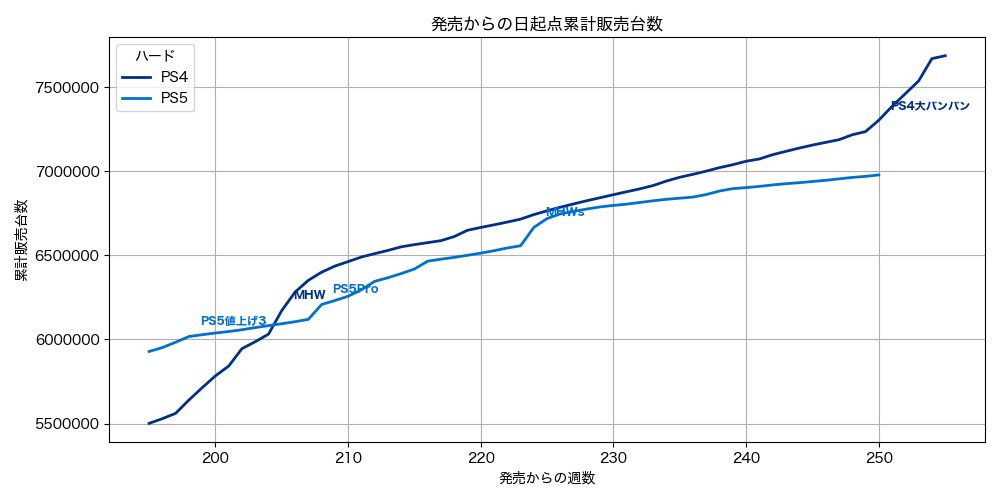

In [13]:
(fig, df) = ph.plot_cumulative_sales_by_delta(hw=['PS4', 'PS5'], begin=195, end=255,
                                              event_priority=1, event_flag=True)

なお、ここまでPS5とPS4の販売傾向は同じ推移を辿ってきましたが、250週からPS4は大盤振る舞いの
「大バンバンキャンペーン」で大きく台数を増やしています。PS5がこの推移に着いていくのは、
普通のキャンペーン程度では困難と予想されるので、ここから先はPS4とPS5の推移は乖離していくでしょう。
もし、これでも乖離しないようなら... 不思議なことですね。

## Switch2販売状況

### 歴代機種との比較

Switch2はGBAに次ぐ歴代2位の初動を維持していますが、しばらくは出荷制限で勢いが落ちます。
ZA発売までにPS2に追いつかれるかどうか。

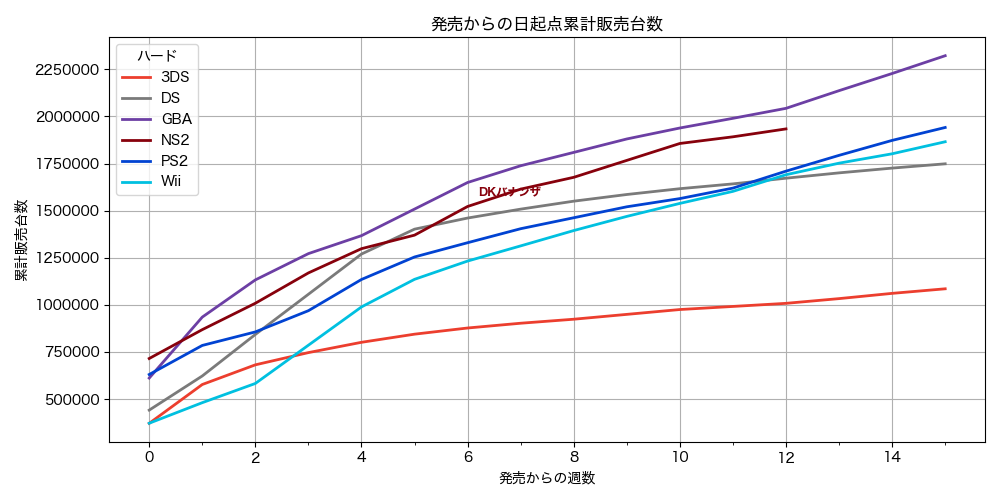

In [7]:
(fig, df) = ph.plot_cumulative_sales_by_delta(hw=["GBA", "NS2", "DS", "PS2", "Wii", "3DS"], 
                                        mode="week", xgrid=2, end=15)

## Switch/Switch2ロンチ比較

ロンチ週以降のSwitchとSwitch2の販売状況(実質的に出荷状況)の比較です。

Switch2が大量出荷される段階は終わり、Switchと同じ推移になってきました。
ZAまではSwitch2の入手困難な状況が続くでしょう。
Switchは20週目にスプラトゥーン2の山がありますが、Switch2も同時期(1,2週前かも)にZAの山が出来そうです。
その2、3週間後には年末商戦の入り口なので、そこでも大量出荷に期待しましょう。


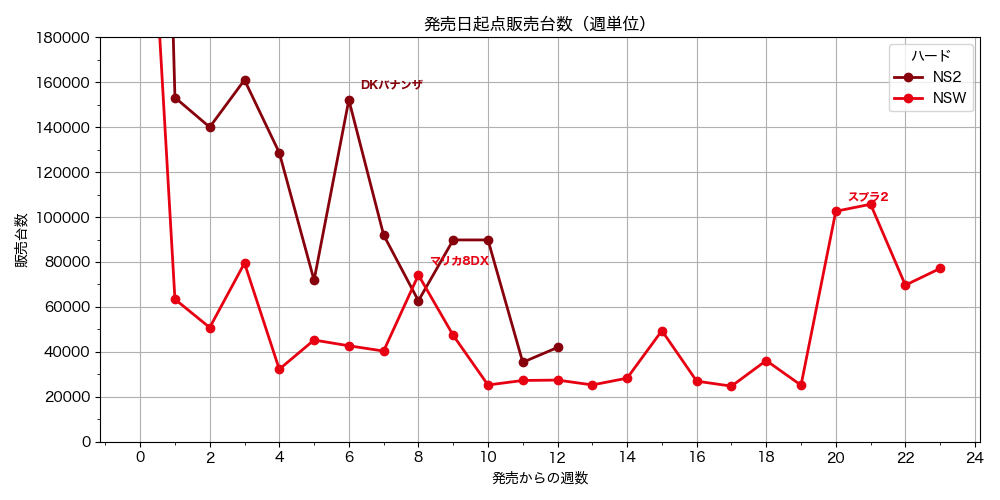

In [14]:
(fig, df) = ph.plot_sales_by_delta(hw=["NSW", "NS2"], end=23, ymax=180000, xgrid=2, ygrid=20000, mode="week", event_flag=True, event_priority=3)


## 年単位の状況

(2025年については8月までの状況です)

Switchが健闘しています。最終的に150万台に到達するかも(それでも昨年比で半減ですが)。
なぜかPS5も落ち込んでいます。年内100万台は難しそうです。

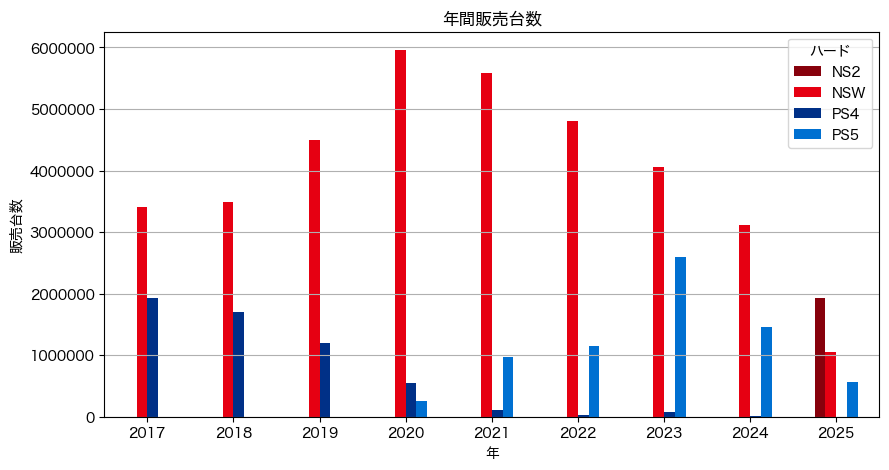

In [11]:
(fig, df) = ph.plot_yearly_histogram(hw=['PS4', 'PS5', 'NSW', 'NS2'], begin=datetime(2017,1,1), end=datetime(2025,12,31))

Switch2の販売台数の延びにより、任天堂が2025年に記録的シェアを達成する可能性が高まっています。

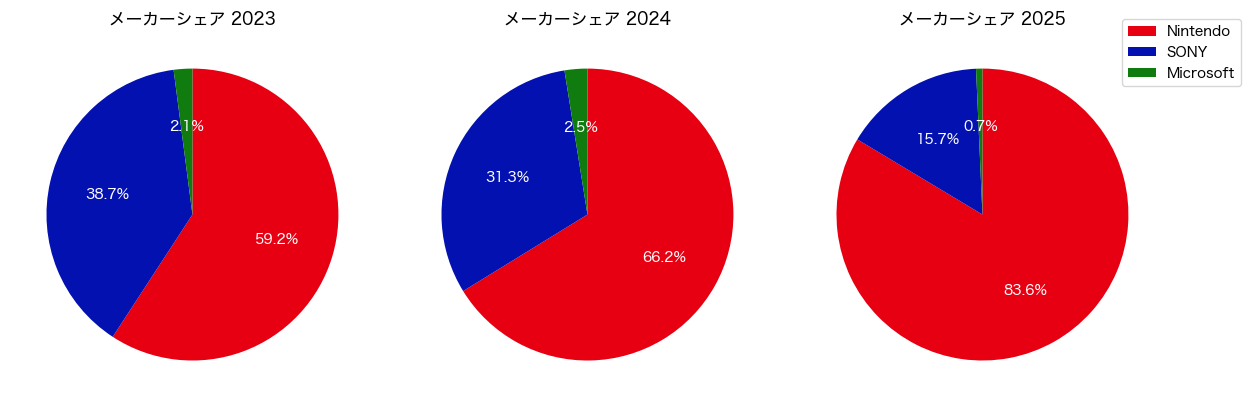

In [12]:
(fig, df) = ph.plot_maker_share_pie(begin_year=2023, end_year=2025)